In [10]:
import requests
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.feature_selection import VarianceThreshold
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from multiprocessing.dummy import Pool as ThreadPool
from requests.auth import HTTPBasicAuth
import requests
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import settings
from sklearn.feature_selection import VarianceThreshold
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from math import ceil
import umap
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import TruncatedSVD

In [11]:
import matplotlib.pyplot as plt 
%matplotlib inline
from matplotlib.pyplot import figure
import seaborn as sns
from multiprocessing import Pool
key = "fcabada09a68ee4989c8773d205528092c38287c8f21707325e92d62596b0544"

In [12]:
train_df = pd.read_csv("train.csv").set_index("time")
plt_data = train_df.transpose()
names_data = train_df.columns
train_df.head()

,BTC,ETH,XEC,SOL,XRP,OMG,BNB,ADA,AVAX,DOT,...,JST,QNT,YFI,TFUEL,CHR,DENT,MINA,ZRX,ANKR,SC
time,,,,,,,,,,,,,,,,,,,,,
1632929760,41937.41,2900.04,29.36,136.33,0.9430,10.34,371.19,2.073,62.78,27.89,...,0.06026,282.24,28959.37,0.2583,0.2734,0.004234,0.0,0.8580,0.07633,0.01399
1632929820,41873.49,2896.89,29.36,136.07,0.9422,10.31,370.96,2.070,62.52,27.86,...,0.06020,277.58,28914.44,0.2579,0.2726,0.004229,0.0,0.8554,0.07621,0.01398
1632929880,41808.69,2887.89,29.36,135.83,0.9393,10.30,370.22,2.069,62.34,27.77,...,0.06004,279.14,28886.75,0.2575,0.2722,0.000200,0.0,0.8520,0.07609,0.01391
1632929940,41776.35,2879.17,29.36,135.68,0.9379,10.28,369.38,2.066,62.37,27.70,...,0.05997,0.00,28805.85,0.2573,0.2720,0.004204,0.0,0.8515,0.00000,0.01389
1632930000,41719.81,2862.91,29.36,135.53,0.9356,10.22,368.40,2.058,62.29,27.58,...,0.05966,0.00,28745.03,0.2562,0.2712,0.004180,0.0,0.8477,0.07551,0.01387


In [13]:
train_data_mean = train_df.rolling(20).mean().dropna()
scaler = StandardScaler()
train_data_mean_scale = scaler.fit_transform(train_data_mean)
train_data_mean_scale.shape

(1422, 100)

In [14]:
def extract_tsfeatures(data, settings):
    long_dfs = pd.DataFrame(
                {
                    0: data.reshape(-1),
                    1: np.arange(data.shape[0]).repeat(data.shape[1])
                }
            )
    long_dfs.shape
    
    s_features = extract_features(
        long_dfs, column_id=1, 
        impute_function=impute, 
        default_fc_parameters=settings,
        n_jobs=6,
        disable_progressbar=True,
        show_warnings=False
    )
    return s_features

In [15]:
settings_efficient = settings.EfficientFCParameters()

X = train_data_mean_scale.transpose()

X = extract_tsfeatures(X, settings_efficient)
print(X.shape)

scaler = StandardScaler()
selector = VarianceThreshold(threshold=0)

X_reduced = selector.fit_transform(X)
X_scaler = scaler.fit_transform(X_reduced)

print(X_scaler.shape)

(100, 781)
(100, 741)


In [74]:
svd = TruncatedSVD(n_components=45)    
X_scaler_decomp = svd.fit_transform(X_scaler)
svd.explained_variance_ratio_.sum()

kmeans = KMeans(n_clusters=28, random_state=0).fit(X_scaler_decomp)
ans = kmeans.labels_

# for claster_k in np.unique(ans):
#     if np.bincount(ans)[claster_k] == 1:
#         continue
#     name_claster = names_data[ans == claster_k]
#     plt.title("cluster {}".format(claster_k))
#     plt.plot(train_data_mean_scale[:, ans == claster_k])
#     plt.savefig("cluster{}".format(claster_k))
#     plt.show()

In [75]:
def plot_df(df, arr, title, one):
    w = 3
    fig = figure(figsize=(10, 8))
    plt.title(title)
    for claster_k in arr:
        if one:
            plt.plot(df[:, ans == claster_k][:, 0], linewidth=w)
        else:
            plt.plot(df[:, ans == claster_k], linewidth=w)
    if one is True:
        plt.legend(arr)
    plt.grid()
    plt.show()

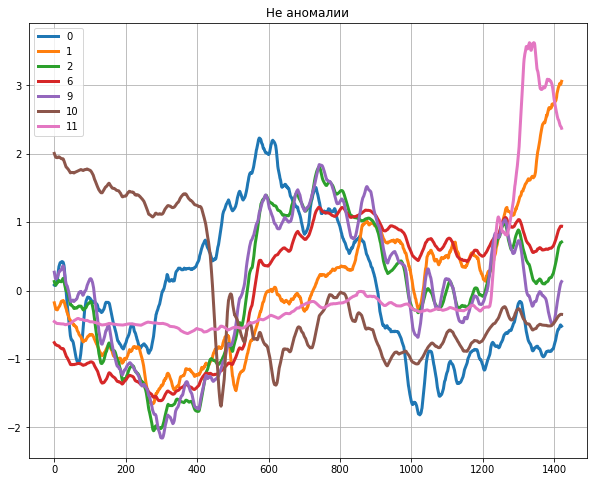

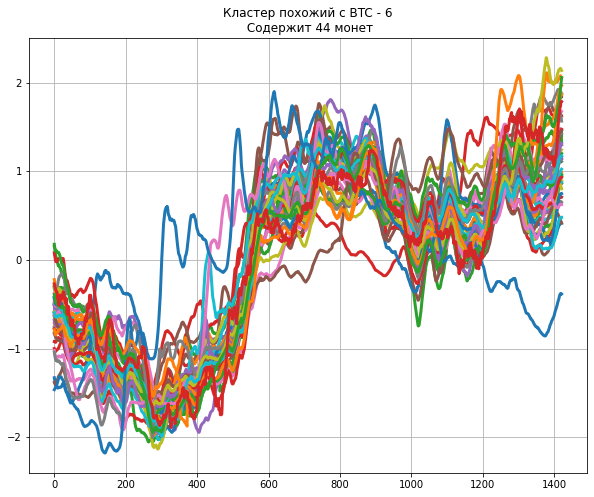

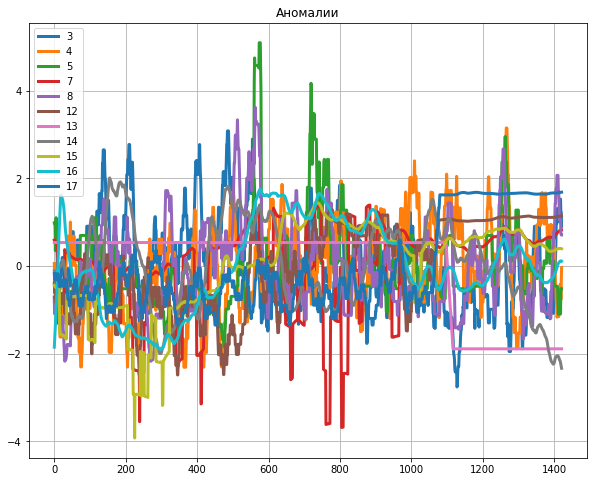

In [83]:
CLUSTER_SIZE = 18

svd = TruncatedSVD(n_components=45)    
X_scaler_decomp = svd.fit_transform(X_scaler)
svd.explained_variance_ratio_.sum()

kmeans = KMeans(n_clusters=CLUSTER_SIZE, random_state=0).fit(X_scaler_decomp)
ans = kmeans.labels_

clusters = np.unique(ans)
counts = np.bincount(ans)
no_anomaly_cluster = clusters[counts != 1]
anomaly_cluster = clusters[counts == 1]

plot_df(train_data_mean_scale, no_anomaly_cluster, "Не аномалии", True)

btc_cluster = ans[names_data == "BTC"][0]
btc_title = "Кластер похожий c BTC - {}\n Содержит {} монет".format(btc_cluster, counts[btc_cluster])
plot_df(train_data_mean_scale, ans[names_data == "BTC"], btc_title, False)

plot_df(train_data_mean_scale, anomaly_cluster, "Aномалии", True)

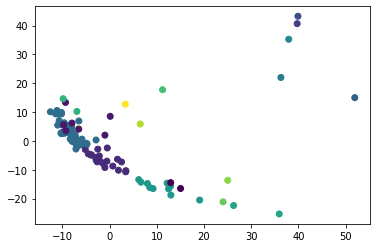

In [85]:
svd = TruncatedSVD(n_components=2)
X_ = svd.fit_transform(X_scaler)
plt.scatter(x=X_[:, 0], y=X_[:, 1], c=ans)

In [56]:
ex_var = []
n_comp = np.arange(100) + 1

for n in n_comp:
    svd = TruncatedSVD(n_components=n)
    X_ = svd.fit_transform(X_scaler)    
    ex_var.append(svd.explained_variance_ratio_.sum())

([<matplotlib.lines.Line2D at 0x7f42dc74e650>], 0.4843774474054371)

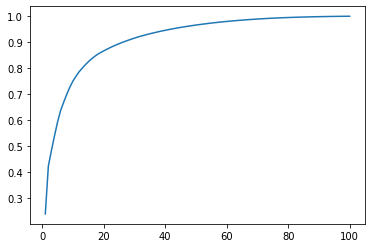

In [59]:
plt.plot(n_comp, ex_var), ex_var[2]

In [48]:
import numpy as np
from sklearn.decomposition import PCA

[0.24061996 0.18395542]
[133.47253889 116.70309901]


In [49]:
ex_var = []
n_comp = np.arange(39) + 1
for i in n_comp:
    pca = PCA(n_components=2)
    pca.fit(X_scaler)

    ex_var.append(pca.explained_variance_ratio_.sum())


([<matplotlib.lines.Line2D at 0x7f42e581be50>], 0.4245753767681768)

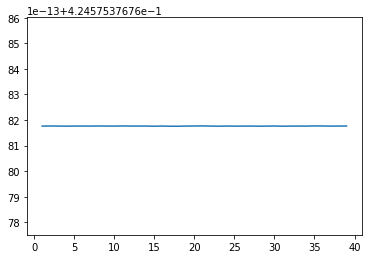

In [50]:
plt.plot(n_comp, ex_var), ex_var[20]

In [3]:
url = "https://min-api.cryptocompare.com/data/top/totalvolfull?limit=100&tsym=USD"
page = requests.get(url)
good_names = np.array([i['CoinInfo']['Name'] for i in page.json()['Data']])
good_names.shape

(100,)

In [12]:
def crypta_daily(title):
    url = "https://min-api.cryptocompare.com/data/v2/histominute?fsym={}&tsym=USD&limit=1440".format(title)
    page = requests.get(url)
    if page.status_code == 200:
        df = pd.DataFrame(page.json()["Data"]["Data"]).rename(columns={"close": title})
        columns_drop = df.columns[[1, 2, 3, 4, 5, 7, 8]]
        df_clean = df.drop(columns_drop, axis=1)
        df_clean.set_index("time", inplace=True)
        return df_clean
    else:
        return None

In [13]:
def make_crypta_df(names):
    df = pd.DataFrame()
    for name in tqdm(names):
        tmp = crypta_daily(name)
        if tmp is not None:
            df = pd.concat([df, tmp], axis=1)
    return df

In [41]:
url = "https://min-api.cryptocompare.com/data/top/totalvolfull?limit=100&tsym=USD"
page = requests.get(url)
good_names = np.array([i['CoinInfo']['Name'] for i in page.json()['Data']])
good_names.shape

(100,)

In [38]:
def get_json(title):
    url = "https://min-api.cryptocompare.com/data/v2/histominute?fsym={}&tsym=USD&limit=1440&api_key={}".format(title, key)
    page = requests.get(url)
    return page.json()["Data"]["Data"]

def make_clean_df(content, title):
    df = pd.DataFrame(content).rename(columns={"close": title})
    columns_drop = df.columns[[1, 2, 3, 4, 5, 7, 8]]
    df_clean = df.drop(columns_drop, axis=1)
    df_clean.set_index("time", inplace=True)
    
    return df_clean

In [39]:
with ThreadPool(15) as pool:
    contents = pool.map(get_json, good_names)

train_df = pd.DataFrame()

for i, title in enumerate(good_names):
    tmp = make_clean_df(contents[i], title)
    train_df = pd.concat([train_df, tmp], axis=1)

In [43]:
#train_df.to_csv("train.csv")

In [51]:
train_data = pd.read_csv("train.csv").set_index("time").transpose()
train_data.shape

(100, 1441)

In [52]:
def extract_tsfeatures(data, settings):
    long_dfs = pd.DataFrame(
                {
                    0: data.reshape(-1),
                    1: np.arange(data.shape[0]).repeat(data.shape[1])
                }
            )
    long_dfs.shape
    
    s_features = extract_features(
        long_dfs, column_id=1, 
        impute_function=impute, 
        default_fc_parameters=settings,
        n_jobs=6,
        disable_progressbar=True,
        show_warnings=False
    )
    return s_features

In [53]:
settings_efficient = settings.EfficientFCParameters()

train_data_pct = train_data.pct_change(periods=1, axis=1)
train_data_pct.replace([np.inf, -np.inf], np.nan, inplace=True)
train_data_pct = train_data_pct.fillna(0)
X = train_data_pct.to_numpy()

X = extract_tsfeatures(X, settings_efficient)
print(X.shape)

scaler = StandardScaler()
selector = VarianceThreshold(threshold=0)

X_reduced = selector.fit_transform(X)
X_scaler = scaler.fit_transform(X_reduced)

print(X_scaler.shape)

(100, 781)
(100, 745)


In [119]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(X_scaler)
ans = kmeans.labels_
np.bincount(ans)

array([96,  1,  2,  1])

In [120]:
plt_data = train_data.transpose()

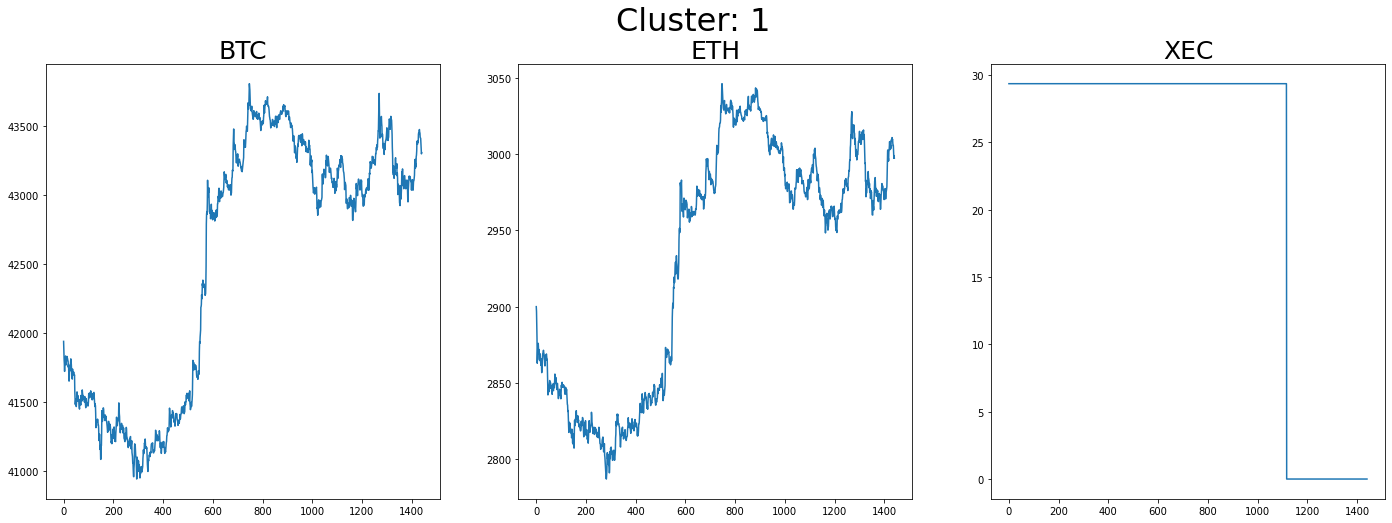

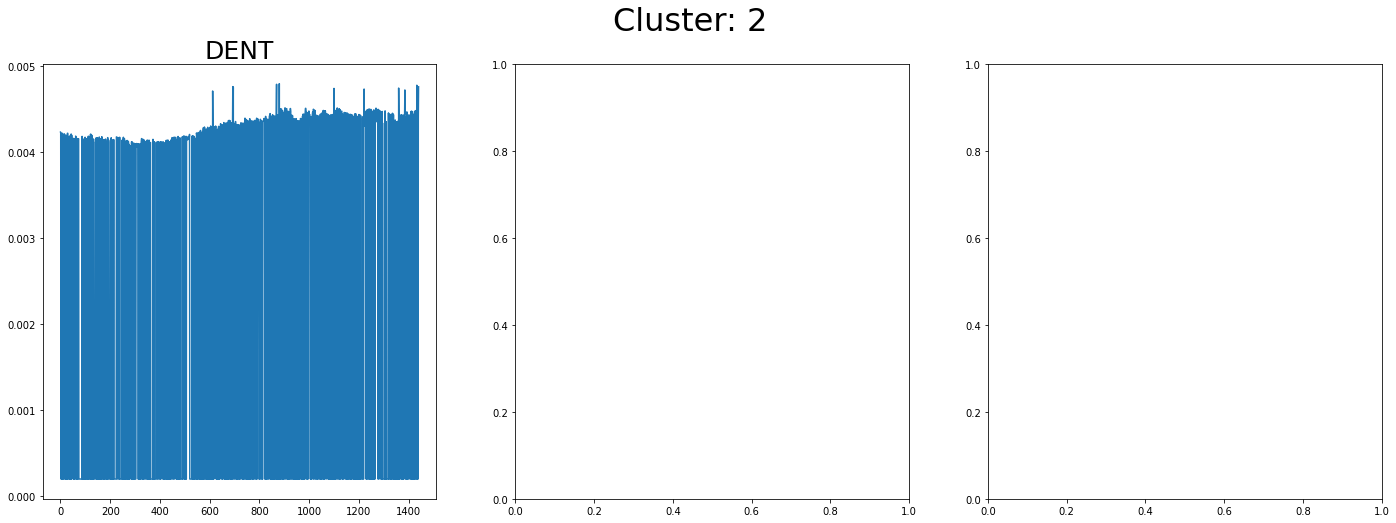

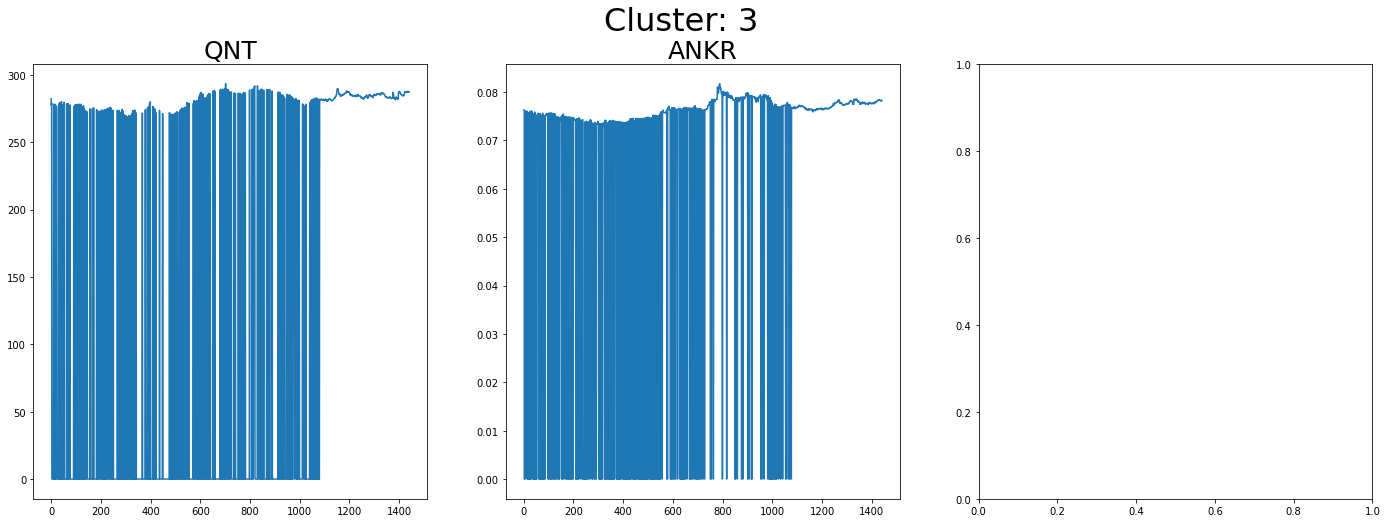

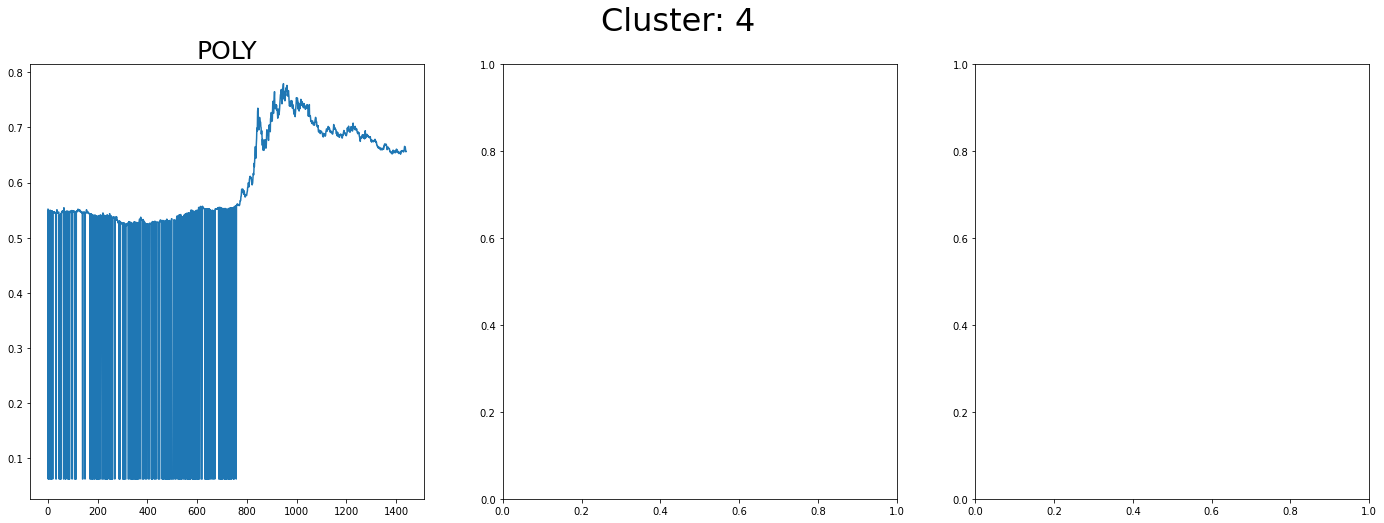

In [121]:
for claster_k in range(len(np.unique(ans))):
    claster_names = good_names[ans == claster_k]
    fig, axis = plt.subplots(1, 3, figsize=(24, 8))

    fig.suptitle('Cluster: {}'.format(claster_k + 1), fontsize=32)

    for i, name in enumerate(claster_names[:3]):
        axis[i % 3].plot(plt_data[name].values)
        axis[i % 3].set_title(name, fontsize=25)

In [130]:
from scipy import stats

In [164]:
df = train_data[~(np.abs(stats.zscore(train_data)) < 1).all(axis=1)]
df

time,1632929760,1632929820,1632929880,1632929940,1632930000,1632930060,1632930120,1632930180,1632930240,1632930300,...,1633015620,1633015680,1633015740,1633015800,1633015860,1633015920,1633015980,1633016040,1633016100,1633016160
BTC,41937.41,41873.49,41808.69,41776.35,41719.81,41793.59,41821.31,41782.92,41831.71,41819.33,...,43472.58,43451.01,43448.13,43416.16,43411.29,43408.29,43364.57,43304.31,43296.24,43305.08
WBTC,41934.58,41862.35,41787.77,41690.38,41655.34,41793.59,41821.31,41792.84,41845.51,41790.36,...,43448.30,43456.46,43461.66,43421.80,43401.73,43403.03,43369.80,43282.60,43307.44,43277.69
YFI,28959.37,28914.44,28886.75,28805.85,28745.03,28773.04,28767.11,28771.08,28788.17,28749.69,...,29077.90,29072.97,29066.58,29060.32,29062.16,29055.41,29029.05,29014.80,29027.74,29040.72


In [204]:
train_data_clean = train_data[(train_data > 0.1).any(1)]

In [205]:
train_data_clean_1 = train_data_clean[train_data_clean > 0.05].dropna()

In [211]:
train_data_clean_1.index

Index(['BTC', 'ETH', 'SOL', 'XRP', 'OMG', 'BNB', 'ADA', 'AVAX', 'DOT', 'BUSD',
       'ATOM', 'LUNA', 'LTC', 'LINK', 'FIL', 'AXS', 'DYDX', 'USDT', 'UNI',
       'XTZ', 'BCH', 'OKB', 'FTT', 'ALGO', 'EOS', 'DOGE', 'ETC', 'COMP',
       'COTI', 'FTM', 'MATIC', 'XLM', 'USDC', 'QTUM', 'ICP', 'THETA', 'SRM',
       'XMR', 'SUSHI', 'HBAR', 'NEO', 'CELR', 'KSM', 'CELO', 'ZEC', 'MIOTA',
       'CRV', 'HT', 'EGLD', 'CAKE', 'ONE', 'KAVA', 'DASH', 'CHZ', 'BSV', 'ELF',
       '1INCH', 'AAVE', 'CVC', 'ONT', 'ICX', 'POLY', 'WBTC', 'WAVES', 'WAXP',
       'PERP', 'GRT', 'SAND', 'AR', 'RUNE', 'MANA', 'SNX', 'FET', 'BAT', 'SXP',
       'LSK', 'HIVE', 'VIDT', 'REN', 'YFI', 'TFUEL', 'CHR', 'ZRX'],
      dtype='object')

In [207]:
settings_efficient = settings.EfficientFCParameters()

train_data_pct = train_data_clean_1.pct_change(periods=1, axis=1)
train_data_pct.replace([np.inf, -np.inf], np.nan, inplace=True)
train_data_pct = train_data_pct.fillna(0)
X = train_data_pct.to_numpy()

X = extract_tsfeatures(X, settings_efficient)
print(X.shape)

scaler = StandardScaler()
selector = VarianceThreshold(threshold=0)

X_reduced = selector.fit_transform(X)
X_scaler = scaler.fit_transform(X_reduced)

print(X_scaler.shape)

(83, 781)
(83, 738)


In [209]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(X_scaler)
ans = kmeans.labels_
np.bincount(ans)

array([ 9,  1,  1, 69,  3])

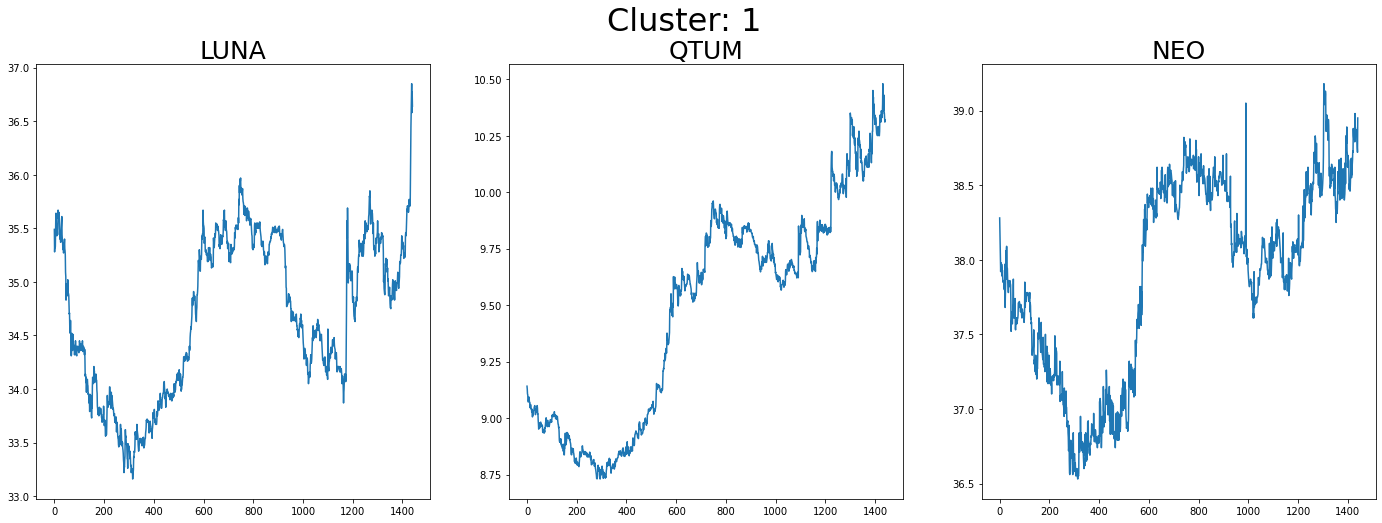

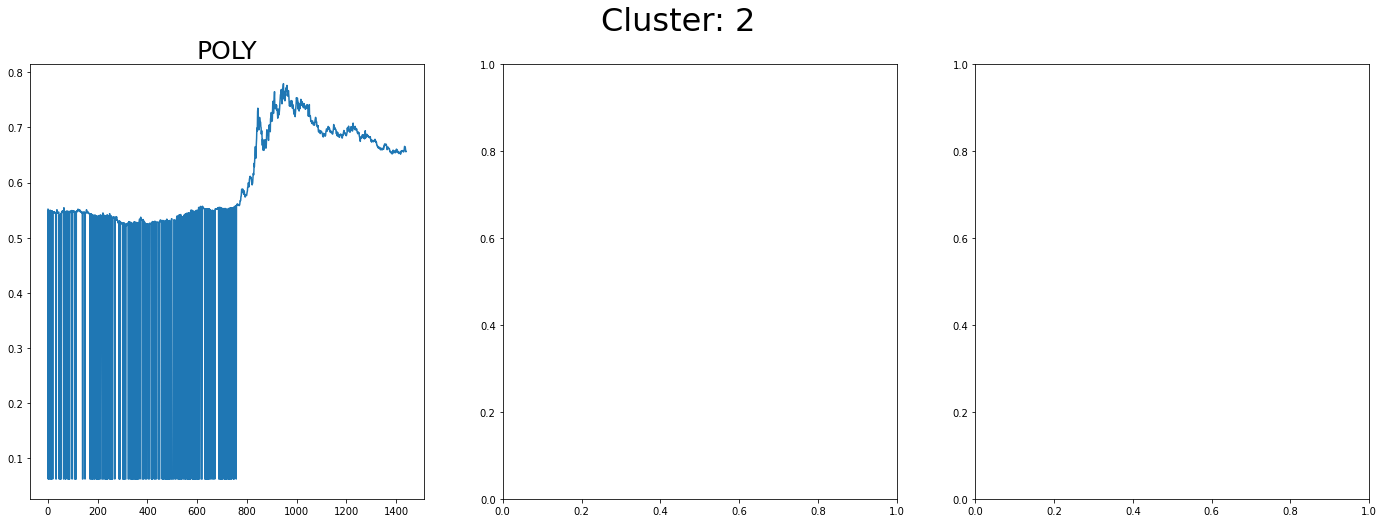

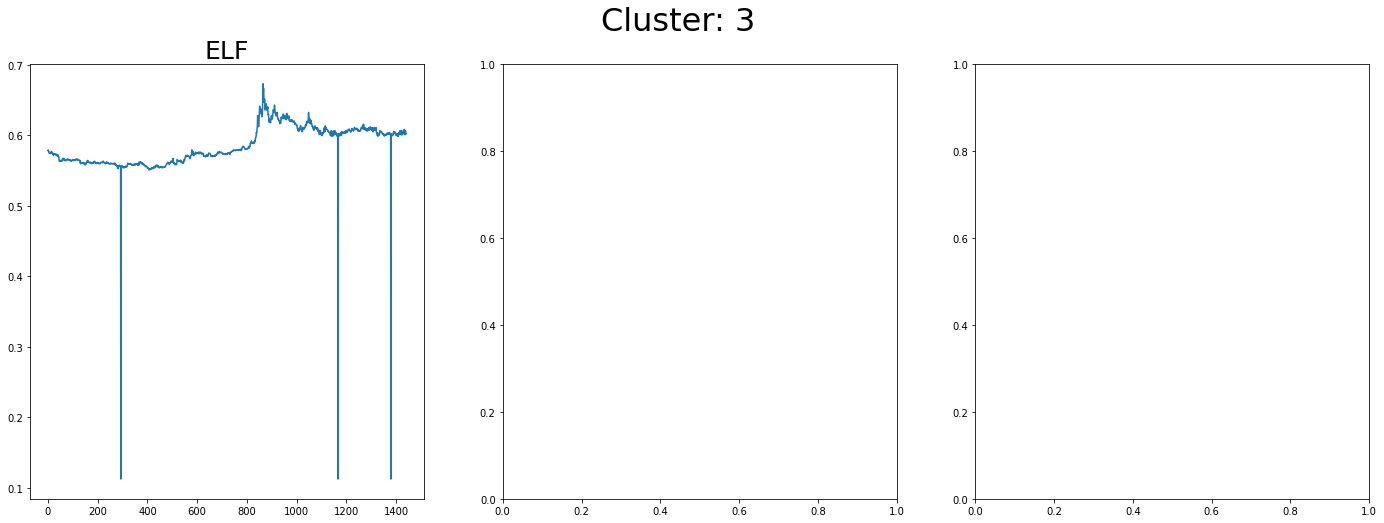

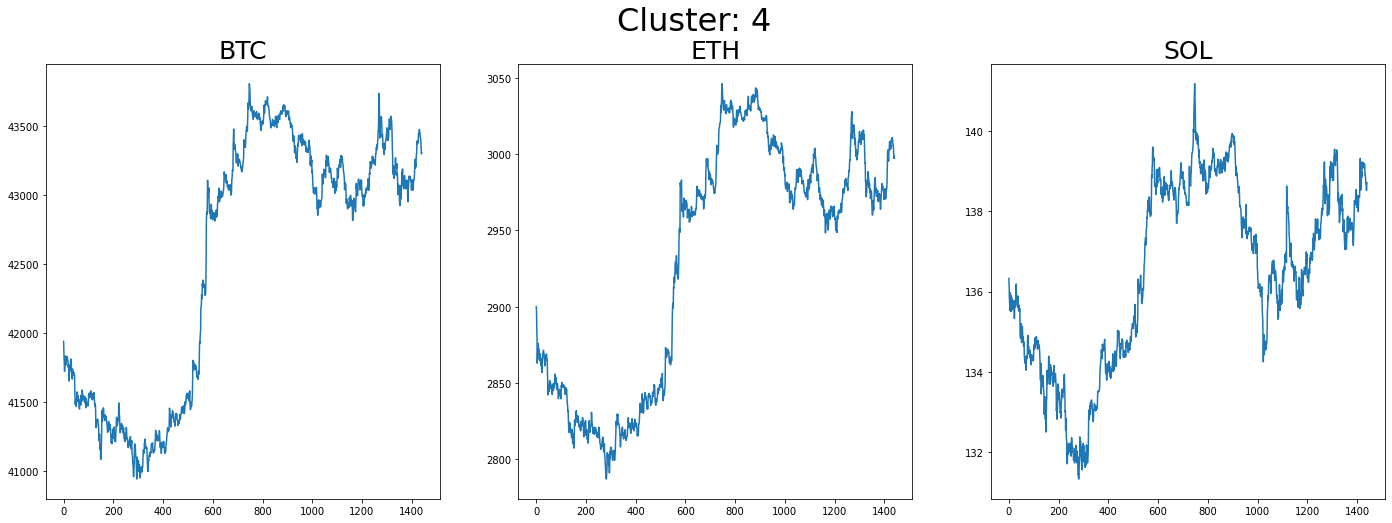

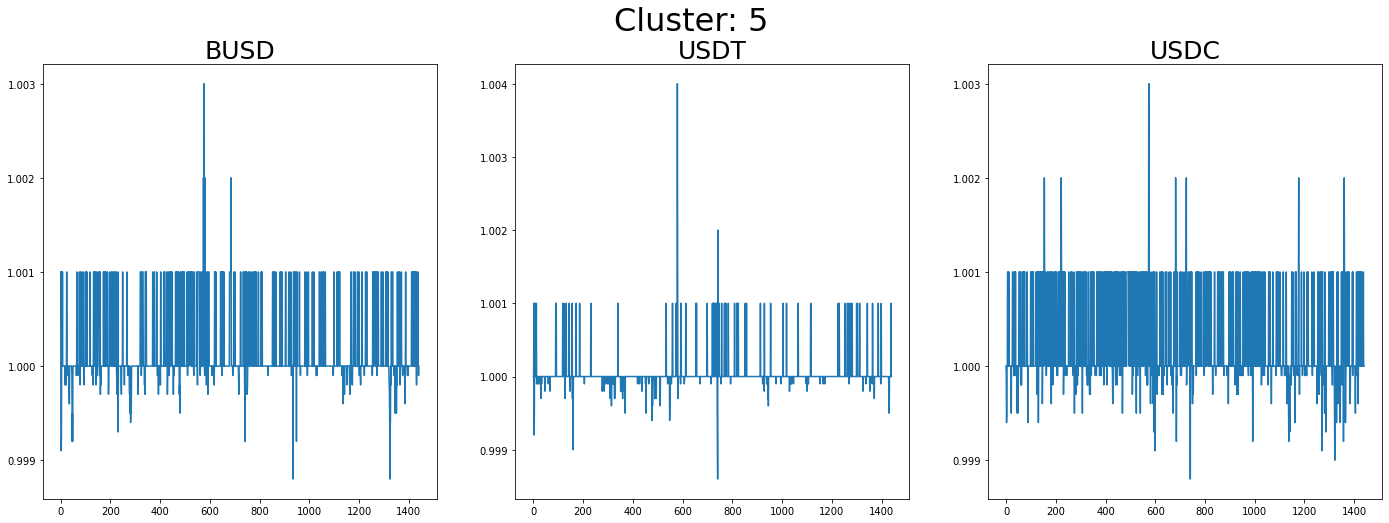

In [212]:
names = train_data_clean_1.index
for claster_k in range(len(np.unique(ans))):
    claster_names = names[ans == claster_k]
    fig, axis = plt.subplots(1, 3, figsize=(24, 8))

    fig.suptitle('Cluster: {}'.format(claster_k + 1), fontsize=32)

    for i, name in enumerate(claster_names[:3]):
        axis[i % 3].plot(plt_data[name].values)
        axis[i % 3].set_title(name, fontsize=25)

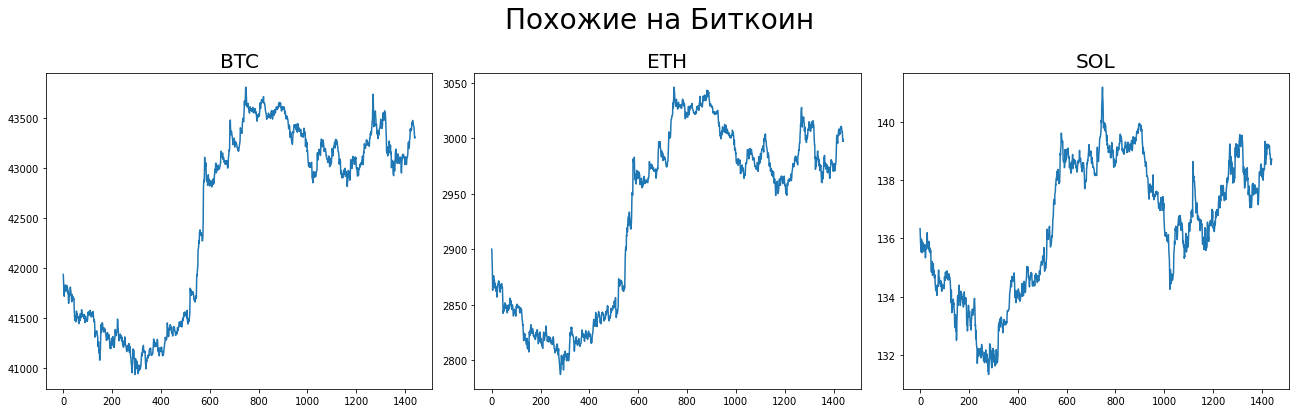

In [237]:
k = 3
claster_names = names[ans == k]
fig, axis = plt.subplots(1, 3, figsize=(18, 6))

fig.suptitle('Похожие на Биткоин', fontsize=28)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
for i, name in enumerate(claster_names[:3]):
    axis[i % 3].plot(plt_data[name].values)
    axis[i % 3].set_title(name, fontsize=20)
plt.savefig('foo.png')

In [280]:
clean_data = plt_data[plt_data > 0.1].fillna(plt_data.mean(0))

In [285]:
clean_data = clean_data.transpose()

In [282]:
names = clean_data.index

In [286]:
clean_data 

,BTC,ETH,XEC,SOL,XRP,OMG,BNB,ADA,AVAX,DOT,...,JST,QNT,YFI,TFUEL,CHR,DENT,MINA,ZRX,ANKR,SC
time,,,,,,,,,,,,,,,,,,,,,
1632929760,41937.41,2900.04,29.360000,136.33,0.9430,10.34,371.19,2.073,62.78,27.89,...,0.060776,282.240000,28959.37,0.2583,0.2734,0.002173,1.034104,0.8580,0.059571,0.014007
1632929820,41873.49,2896.89,29.360000,136.07,0.9422,10.31,370.96,2.070,62.52,27.86,...,0.060776,277.580000,28914.44,0.2579,0.2726,0.002173,1.034104,0.8554,0.059571,0.014007
1632929880,41808.69,2887.89,29.360000,135.83,0.9393,10.30,370.22,2.069,62.34,27.77,...,0.060776,279.140000,28886.75,0.2575,0.2722,0.002173,1.034104,0.8520,0.059571,0.014007
1632929940,41776.35,2879.17,29.360000,135.68,0.9379,10.28,369.38,2.066,62.37,27.70,...,0.060776,128.650347,28805.85,0.2573,0.2720,0.002173,1.034104,0.8515,0.059571,0.014007
1632930000,41719.81,2862.91,29.360000,135.53,0.9356,10.22,368.40,2.058,62.29,27.58,...,0.060776,128.650347,28745.03,0.2562,0.2712,0.002173,1.034104,0.8477,0.059571,0.014007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1633015920,43408.29,3005.75,22.758637,138.71,0.9466,11.84,380.41,2.100,65.59,28.25,...,0.060776,287.590000,29055.41,0.2583,0.2943,0.002173,4.049000,0.8885,0.059571,0.014007
1633015980,43364.57,3001.37,22.758637,138.64,0.9464,11.84,380.09,2.097,65.44,28.25,...,0.060776,287.840000,29029.05,0.2580,0.2940,0.002173,4.042000,0.8896,0.059571,0.014007
1633016040,43304.31,2997.41,22.758637,138.52,0.9456,11.83,379.81,2.096,65.43,28.24,...,0.060776,287.390000,29014.80,0.2577,0.2936,0.002173,4.035000,0.8919,0.059571,0.014007


In [293]:
clean_data["QNT"].describe()

count    1441.000000
mean      198.644706
std        76.564628
min       128.650347
25%       128.650347
50%       128.650347
75%       282.940000
max       293.480000
Name: QNT, dtype: float64

In [321]:
q_15, q_75 = plt_data.quantile(0.15), plt_data.quantile(0.88)

In [327]:
clean_data = plt_data[(plt_data >= q_15) & (plt_data <= q_75)].fillna(plt_data.rolling(10).mean())

In [339]:
plt_data = train_data.drop(["DENT", "ANKR", "QNT", "POLY", "USDC", "USDT", "XEC", "MINA", "BUSD"], axis=0).transpose()

In [340]:
names = plt_data.columns
names

Index(['BTC', 'ETH', 'SOL', 'XRP', 'OMG', 'BNB', 'ADA', 'AVAX', 'DOT', 'ATOM',
       'LUNA', 'LTC', 'LINK', 'FIL', 'AXS', 'DYDX', 'UNI', 'XTZ', 'BCH', 'OKB',
       'FTT', 'ALGO', 'TRX', 'EOS', 'DOGE', 'ETC', 'COMP', 'IOST', 'COTI',
       'FTM', 'MATIC', 'XLM', 'QTUM', 'ICP', 'THETA', 'SRM', 'VET', 'XMR',
       'SUSHI', 'ZIL', 'HBAR', 'NEAR', 'BTT', 'NEO', 'CELR', 'KSM', 'CELO',
       'ZEC', 'MIOTA', 'CRV', 'HT', 'EGLD', 'CAKE', 'STPT', 'ONE', 'KAVA',
       'DASH', 'CHZ', 'BSV', 'ELF', '1INCH', 'AAVE', 'CVC', 'ONT', 'ICX',
       'WBTC', 'WAVES', 'WAXP', 'PERP', 'GRT', 'SAND', 'IOTX', 'AR', 'NFT',
       'RUNE', 'MANA', 'SNX', 'FET', 'BAT', 'SXP', 'LSK', 'HIVE', 'SHIB',
       'VIDT', 'REN', 'JST', 'YFI', 'TFUEL', 'CHR', 'ZRX', 'SC'],
      dtype='object')

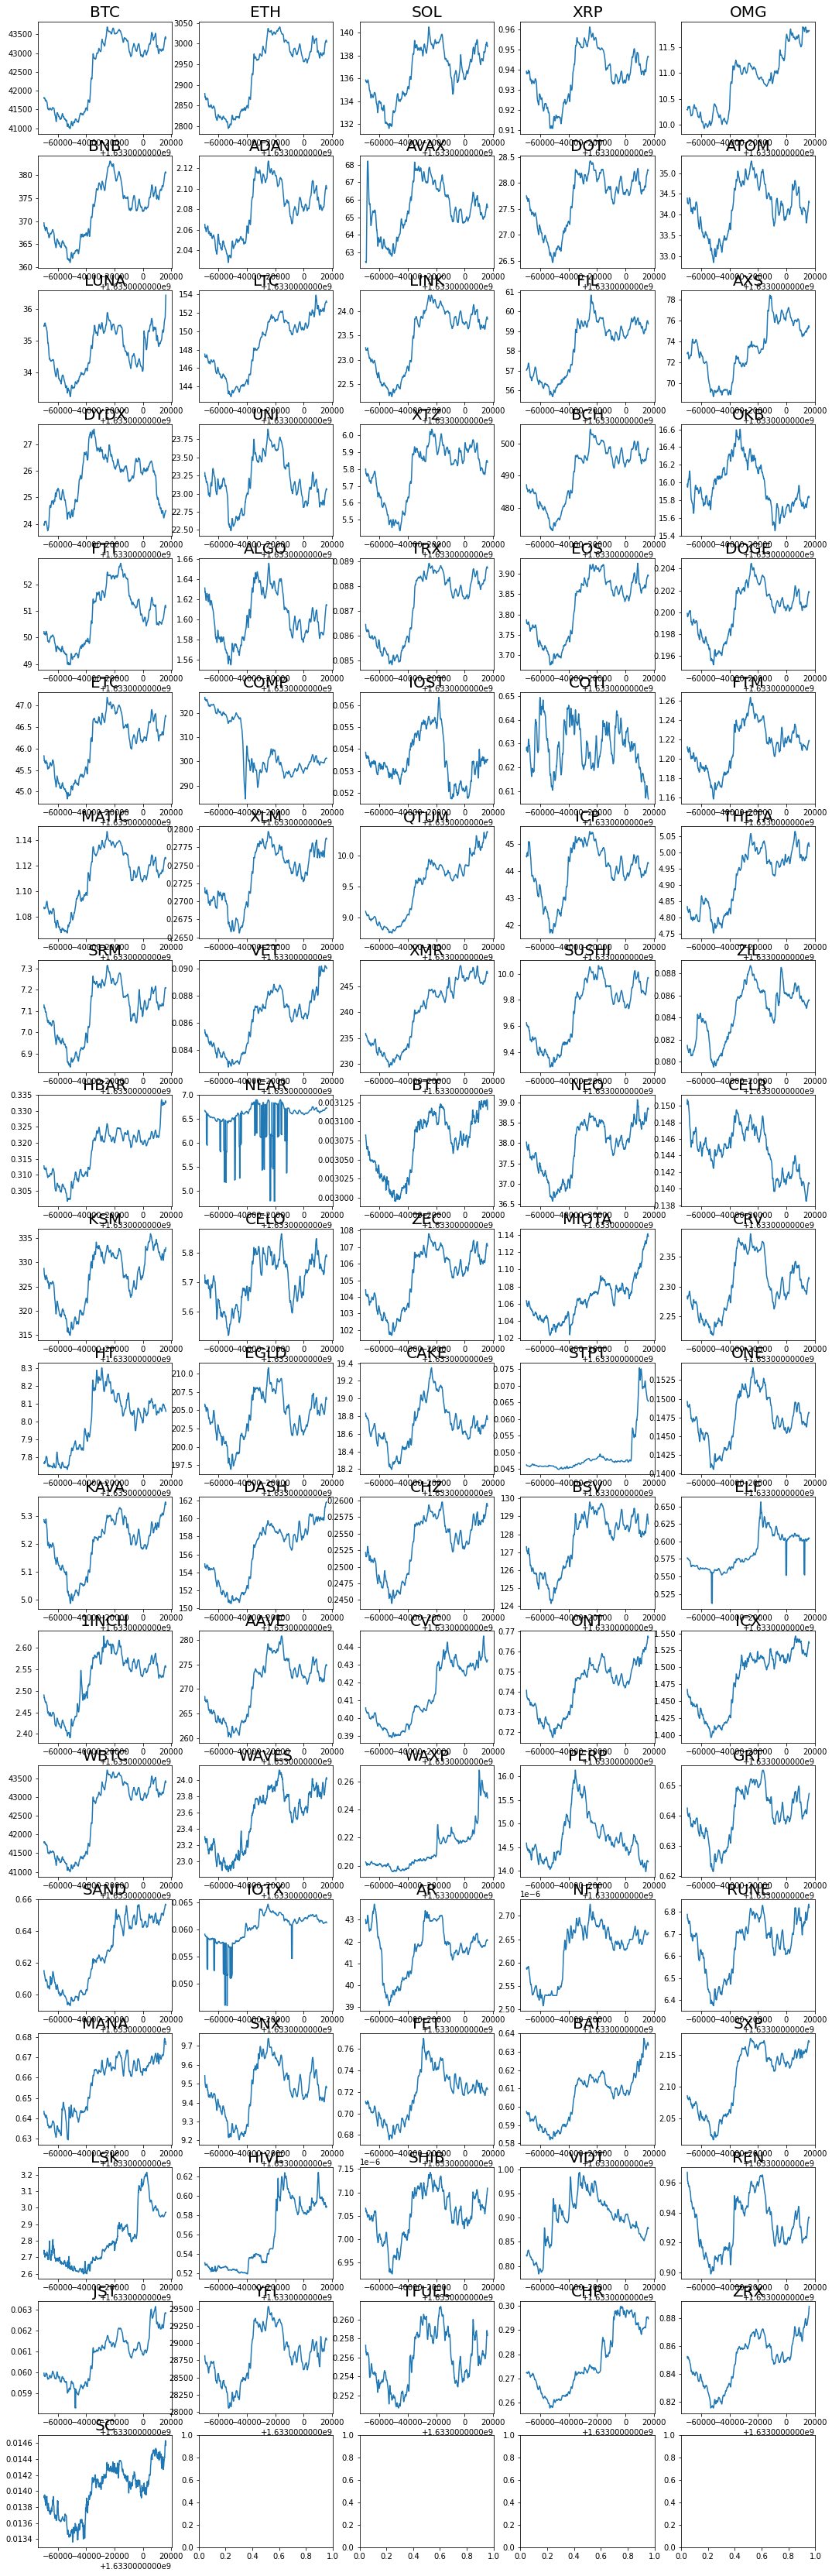

In [344]:
fig, axis = plt.subplots(19, 5, figsize=(18, 60))

for i, name in enumerate(names):
    axis[i// 5, i % 5].plot(plt_data[name].rolling(10).mean())
    axis[i// 5, i % 5].set_title(name, fontsize=20)

In [352]:
train_data_new = plt_data.rolling(10).mean().dropna().transpose()

In [355]:
settings_efficient = settings.EfficientFCParameters()

train_data_pct = train_data_new.pct_change(periods=1, axis=1)
train_data_pct.replace([np.inf, -np.inf], np.nan, inplace=True)
train_data_pct = train_data_pct.fillna(0)
X = train_data_pct.to_numpy()

X = extract_tsfeatures(X, settings_efficient)
print(X.shape)

scaler = StandardScaler()
selector = VarianceThreshold(threshold=0)

X_reduced = selector.fit_transform(X)
X_scaler = scaler.fit_transform(X_reduced)

print(X_scaler.shape)

(91, 781)
(91, 732)


In [356]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(X_scaler)
ans = kmeans.labels_
np.bincount(ans)

array([13,  1,  1,  1, 75])

In [359]:
print(names[ans == 4])

Index(['BTC', 'ETH', 'SOL', 'XRP', 'BNB', 'ADA', 'DOT', 'ATOM', 'LUNA', 'LTC',
       'LINK', 'FIL', 'AXS', 'UNI', 'XTZ', 'BCH', 'OKB', 'FTT', 'ALGO', 'TRX',
       'EOS', 'DOGE', 'ETC', 'COMP', 'FTM', 'MATIC', 'XLM', 'QTUM', 'ICP',
       'THETA', 'SRM', 'VET', 'XMR', 'SUSHI', 'ZIL', 'HBAR', 'BTT', 'NEO',
       'CELR', 'KSM', 'CELO', 'ZEC', 'MIOTA', 'CRV', 'HT', 'EGLD', 'CAKE',
       'ONE', 'KAVA', 'DASH', 'CHZ', 'BSV', '1INCH', 'AAVE', 'CVC', 'ONT',
       'ICX', 'WBTC', 'WAVES', 'GRT', 'SAND', 'AR', 'NFT', 'RUNE', 'MANA',
       'SNX', 'BAT', 'SXP', 'SHIB', 'REN', 'JST', 'YFI', 'TFUEL', 'CHR',
       'ZRX'],
      dtype='object')


In [361]:
plt_data = train_data_new.transpose()

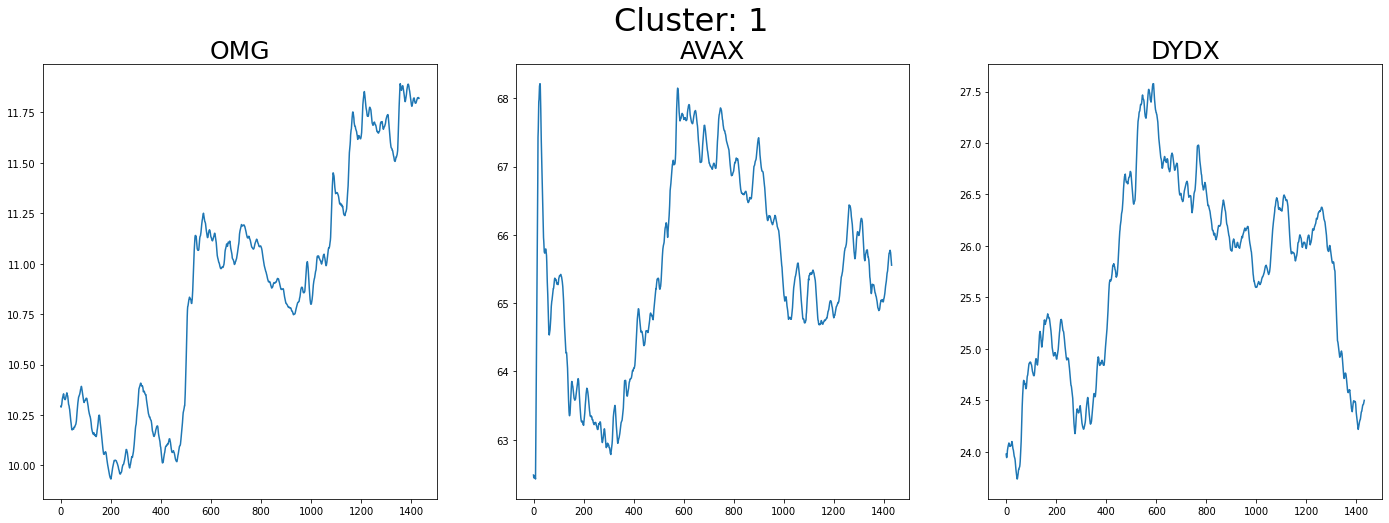

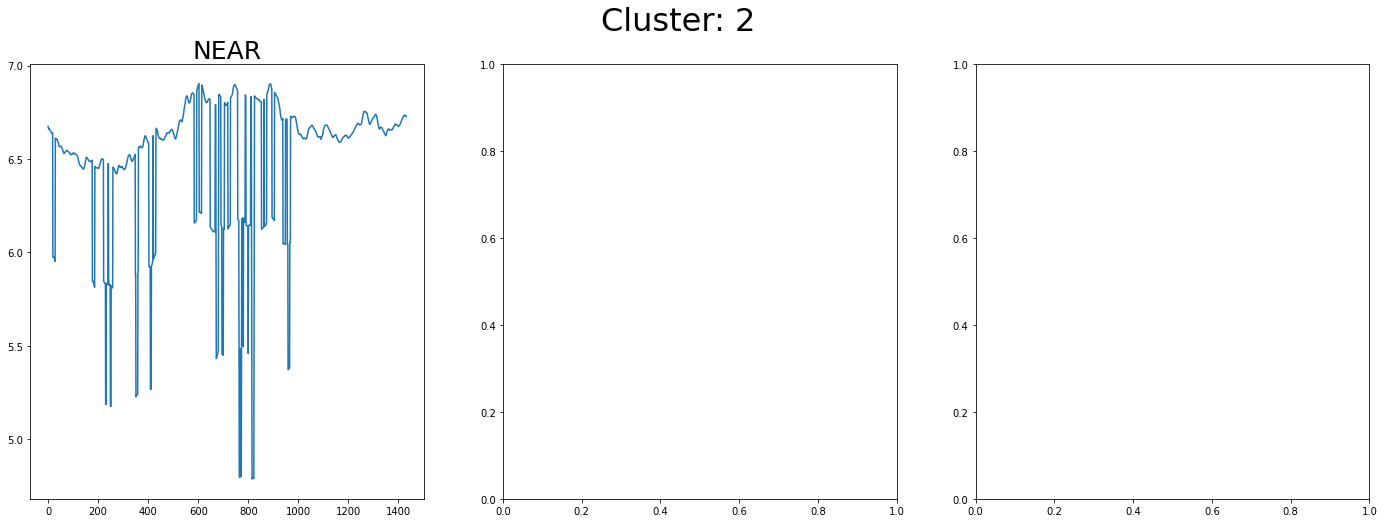

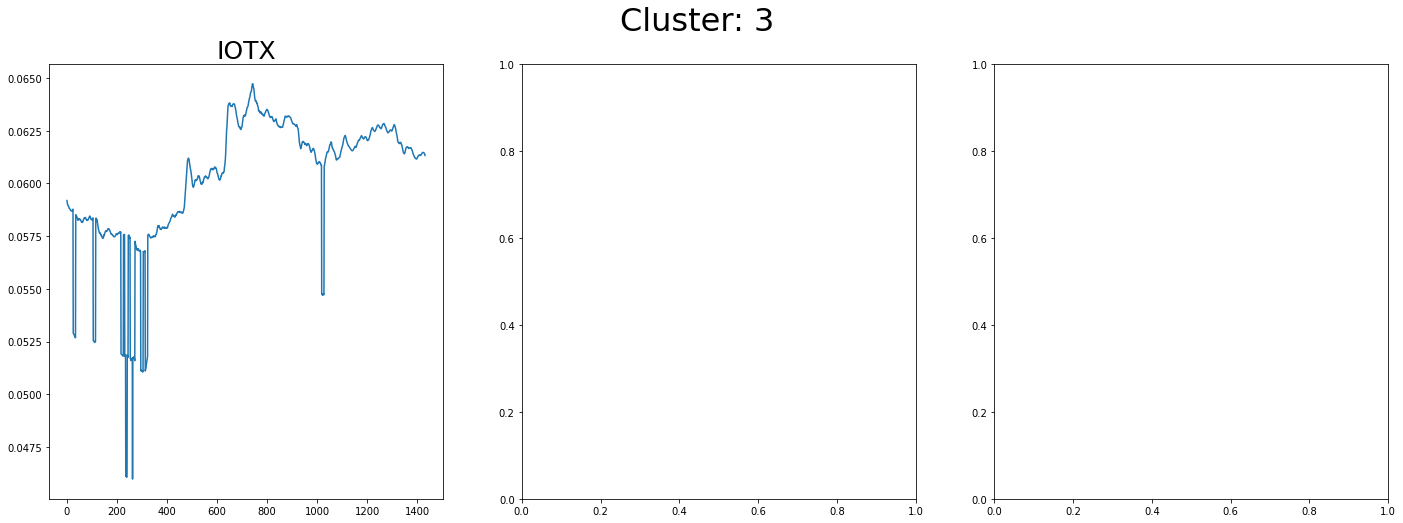

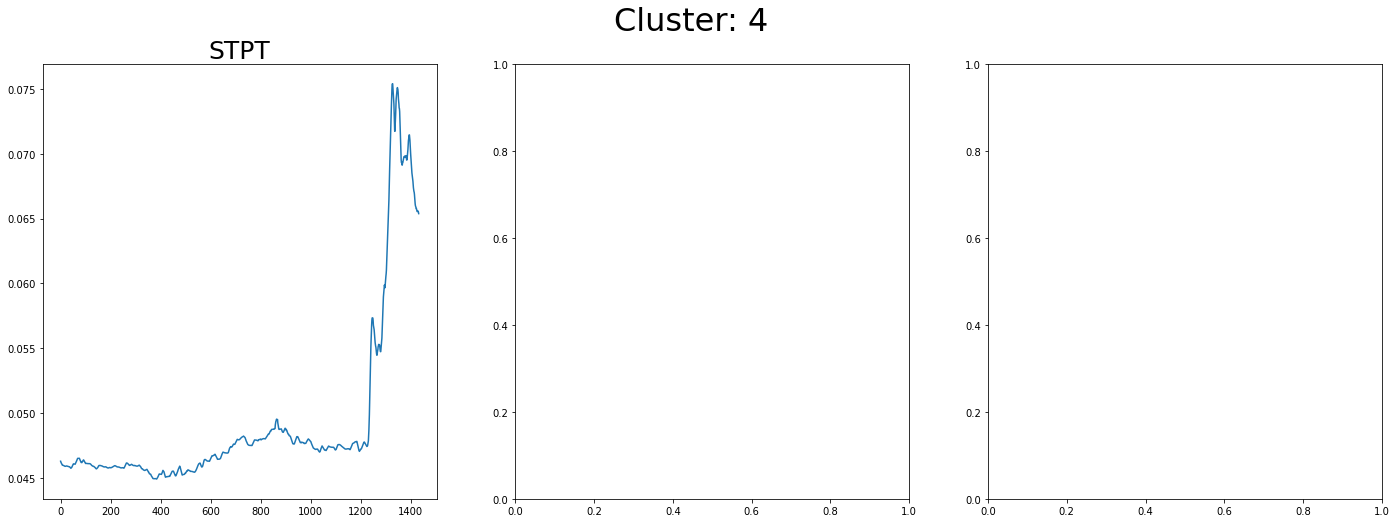

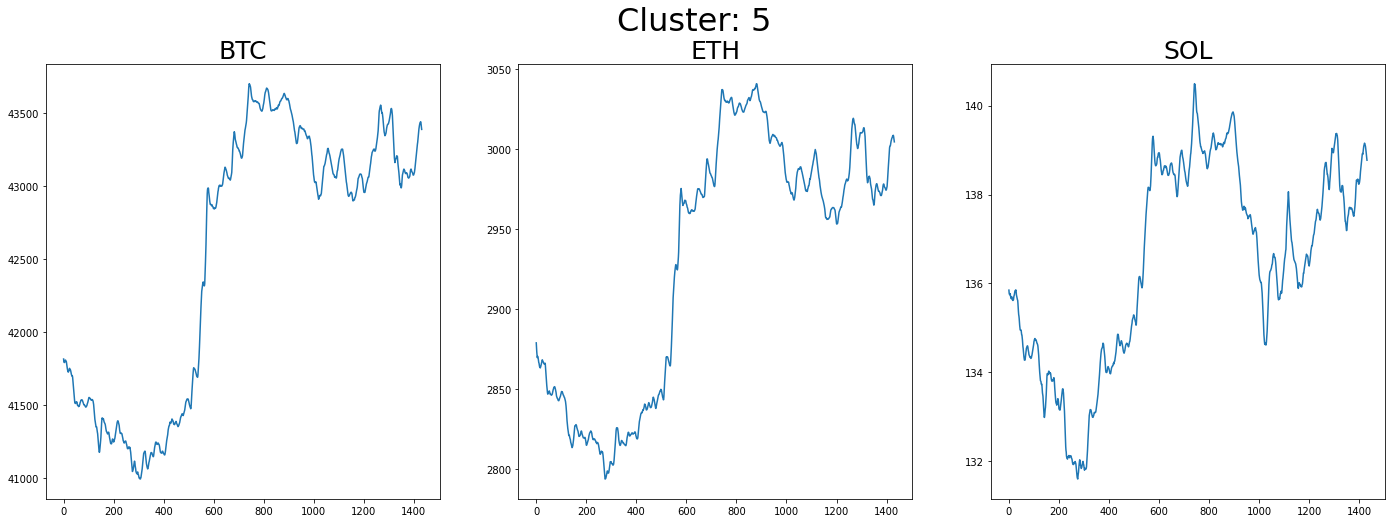

In [362]:
for claster_k in range(len(np.unique(ans))):
    claster_names = names[ans == claster_k]
    fig, axis = plt.subplots(1, 3, figsize=(24, 8))

    fig.suptitle('Cluster: {}'.format(claster_k + 1), fontsize=32)

    for i, name in enumerate(claster_names[:3]):
        axis[i % 3].plot(plt_data[name].values)
        axis[i % 3].set_title(name, fontsize=25)

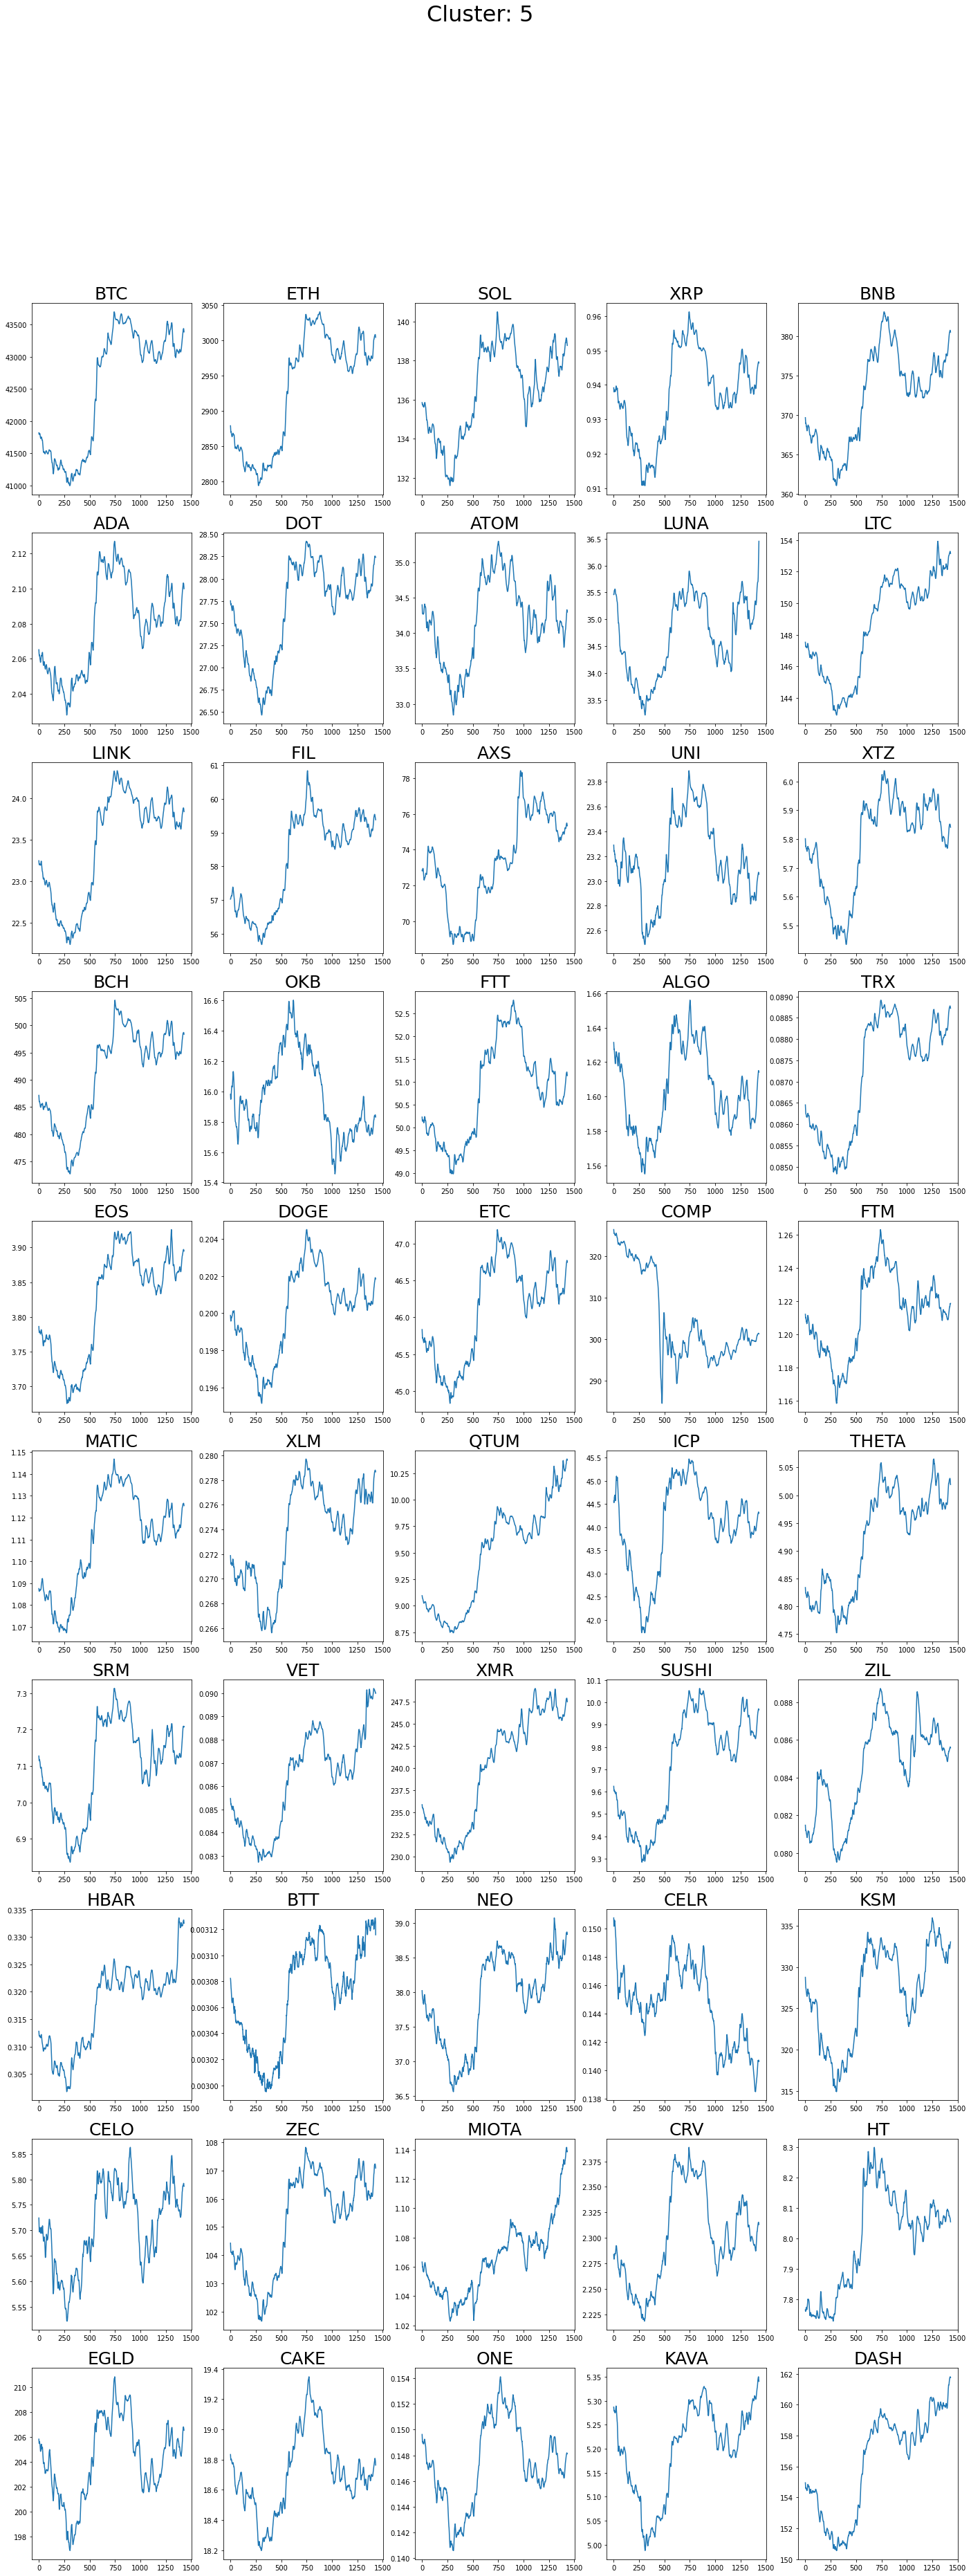

In [365]:
claster_k = 4
claster_names = names[ans == claster_k]
fig, axis = plt.subplots(10, 5, figsize=(24, 60))

fig.suptitle('Cluster: {}'.format(claster_k + 1), fontsize=32)

for i, name in enumerate(claster_names[:50]):
    axis[i//5, i % 5].plot(plt_data[name].values)
    axis[i//5, i % 5].set_title(name, fontsize=25)